In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
file_path = '/content/drive/My Drive/Disease.csv'
import pandas as pd
df = pd.read_csv(file_path)


In [ ]:
df.head()


,Disease,Fever,Cough,Fatigue,Difficulty Breathing,Age,Gender,Blood Pressure,Cholesterol Level,Outcome Variable
0,Influenza,Yes,No,Yes,Yes,19,Female,Low,Normal,Positive
1,Common Cold,No,Yes,Yes,No,25,Female,Normal,Normal,Negative
2,Eczema,No,Yes,Yes,No,25,Female,Normal,Normal,Negative
3,Asthma,Yes,Yes,No,Yes,25,Male,Normal,Normal,Positive
4,Asthma,Yes,Yes,No,Yes,25,Male,Normal,Normal,Positive


In [ ]:
df.shape

(349, 11)

In [ ]:
# checking for missing values
df.isnull().sum()

,0
Disease,0
Fever,0
Cough,0
Fatigue,0
Difficulty Breathing,0
Age,0
Gender,0
Blood Pressure,0
Cholesterol Level,0
Outcome Variable,0


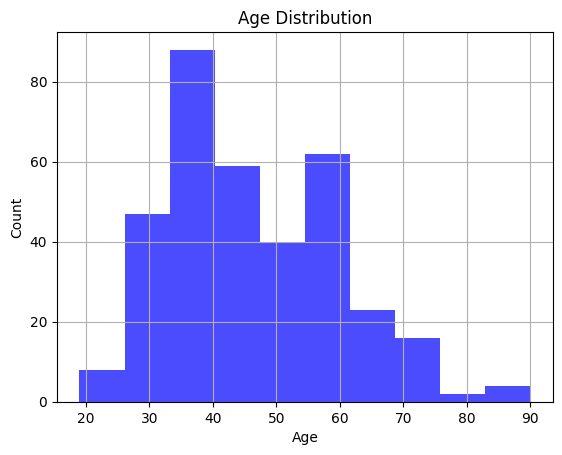

In [ ]:
# EDA
import seaborn as sns
import matplotlib.pyplot as plt
df['Age'].hist(bins=10, color='blue', alpha=0.7)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

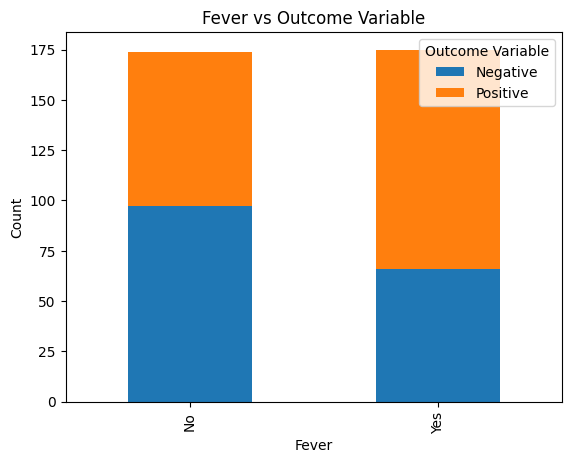

In [ ]:
pd.crosstab(df['Fever'], df['Outcome Variable']).plot(kind='bar', stacked=True)
plt.title('Fever vs Outcome Variable')
plt.xlabel('Fever')
plt.ylabel('Count')
plt.show()

The output will tell you the prior probability for each class based on how the data is split. A high imbalance in the dataset might mean the model is prone to favoring the majority class (this can lead to biased predictions).

In [ ]:
# converting categorical columns to numeric
df['Fever'] = df['Fever'].map({'Yes': 1, 'No': 0})
df['Cough'] = df['Cough'].map({'Yes': 1, 'No': 0})
df['Fatigue'] = df['Fatigue'].map({'Yes': 1, 'No': 0})
df['Difficulty Breathing'] = df['Difficulty Breathing'].map({'Yes': 1, 'No': 0})


In [ ]:
# mapping outcome variable to 0 or 1
df['Outcome Variable'] = df['Outcome Variable'].map({'Positive': 1, 'Negative': 0})


In [ ]:
# gender, cholestrol levels, and blood pressure is being one-hot encoded
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])
df = pd.get_dummies(df, columns=['Blood Pressure', 'Cholesterol Level'], drop_first=True)


In [ ]:
# feature selection, we are just looking to see if there is a disease, we do not care about which disease it is
df = df.drop('Disease', axis=1)

In [ ]:
# split into X, y features
X = df.drop('Outcome Variable', axis=1)
y = df['Outcome Variable']


In [ ]:
#split train, test, and validation
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)



In [ ]:
# Priors
prior_positive = y_train.mean()  # P(Positive)
prior_negative = 1 - prior_positive  # P(Negative)

In [ ]:
# Likelihoods for categorical features
likelihoods = {}
for col in X_train.columns:
    likelihoods[col] = {}
    for outcome in [0, 1]:  # 0 = Negative, 1 = Positive
        likelihoods[col][outcome] = (
            X_train[y_train == outcome][col].value_counts(normalize=True).to_dict()
        )

In [ ]:
# Display likelihoods
import pprint
pprint.pprint(likelihoods)

{'Age': {0: {25: 0.017391304347826087,
             28: 0.008695652173913044,
             29: 0.043478260869565216,
             30: 0.06086956521739131,
             31: 0.017391304347826087,
             35: 0.10434782608695652,
             38: 0.06956521739130435,
             40: 0.043478260869565216,
             42: 0.08695652173913043,
             45: 0.13043478260869565,
             48: 0.008695652173913044,
             50: 0.1391304347826087,
             52: 0.008695652173913044,
             55: 0.10434782608695652,
             57: 0.008695652173913044,
             60: 0.06956521739130435,
             65: 0.02608695652173913,
             70: 0.05217391304347826},
         1: {19: 0.007751937984496124,
             25: 0.015503875968992248,
             28: 0.007751937984496124,
             29: 0.023255813953488372,
             30: 0.09302325581395349,
             31: 0.015503875968992248,
             32: 0.007751937984496124,
             35: 0.10077519379844961

In [ ]:
def compute_posterior(instance, priors, likelihoods):
    posteriors = {}
    for outcome in [0, 1]:  # 0 = Negative, 1 = Positive
        posterior = priors[outcome]  # Start with the prior
        for feature, value in instance.items():
            if value in likelihoods[feature][outcome]:
                posterior *= likelihoods[feature][outcome][value]
            else:
                posterior *= 1e-6  # Smoothing for unseen values
        posteriors[outcome] = posterior
    # Normalize posteriors
    total = sum(posteriors.values())
    for key in posteriors:
        posteriors[key] /= total
    return posteriors


In [ ]:
# Validate the model on the validation set
from sklearn.metrics import accuracy_score, classification_report

predictions_val = []
for i in range(len(X_val)):
    instance = X_val.iloc[i].to_dict()

    #posterior prob
    posteriors = compute_posterior(instance, {0: prior_negative, 1: prior_positive}, likelihoods)

    # predict class with highest posterior prob
    predicted = max(posteriors, key=posteriors.get)
    predictions_val.append(predicted)

print("Validation Accuracy:", accuracy_score(y_val, predictions_val))
print("\nValidation Classification Report:\n", classification_report(y_val, predictions_val))

Validation Accuracy: 0.6153846153846154

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.54      0.57        24
           1       0.63      0.68      0.66        28

    accuracy                           0.62        52
   macro avg       0.61      0.61      0.61        52
weighted avg       0.61      0.62      0.61        52



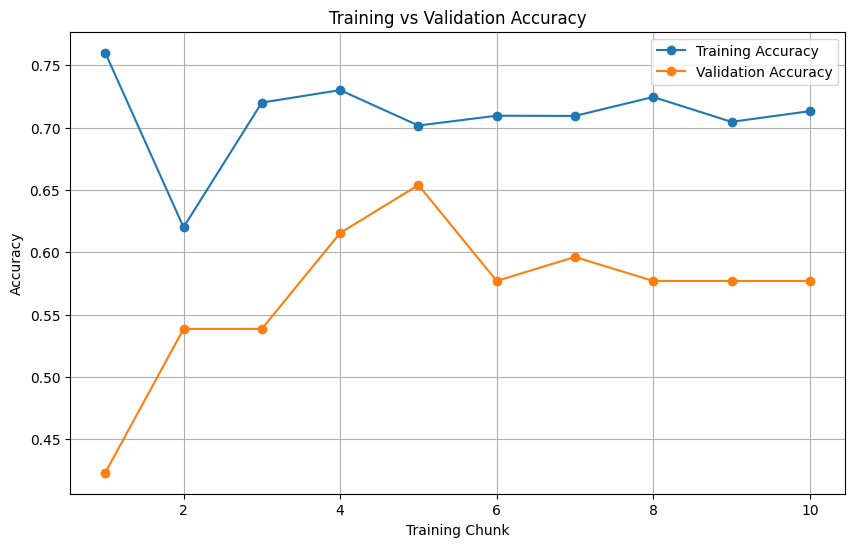

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

training_accuracies = []
validation_accuracies = []

chunks = np.array_split(X_train.index, 10)

for i in range(1, len(chunks) + 1):
    current_train_indices = np.concatenate(chunks[:i])
    X_chunk = X_train.loc[current_train_indices]
    y_chunk = y_train.loc[current_train_indices]

    # Calculate priors
    prior_positive = y_chunk.mean()  # P(Positive)
    prior_negative = 1 - prior_positive  # P(Negative)

    # Recompute likelihoods for the current chunk
    likelihoods = {}
    for col in X_chunk.columns:
        likelihoods[col] = {}
        for outcome in [0, 1]:  # 0 = Negative, 1 = Positive
            likelihoods[col][outcome] = (
                (X_chunk[y_chunk == outcome][col].value_counts() + 1) /
                (y_chunk.value_counts()[outcome] + X_chunk[col].nunique())
            ).to_dict()

    # Training accuracy
    training_preds = []
    for j in range(len(X_chunk)):
        instance = X_chunk.iloc[j].to_dict()
        posteriors = compute_posterior(instance, {0: prior_negative, 1: prior_positive}, likelihoods)
        training_preds.append(max(posteriors, key=posteriors.get))
    training_acc = accuracy_score(y_chunk, training_preds)
    training_accuracies.append(training_acc)

    # Validation accuracy
    validation_preds = []
    for k in range(len(X_val)):
        instance = X_val.iloc[k].to_dict()
        posteriors = compute_posterior(instance, {0: prior_negative, 1: prior_positive}, likelihoods)
        validation_preds.append(max(posteriors, key=posteriors.get))
    val_acc = accuracy_score(y_val, validation_preds)
    validation_accuracies.append(val_acc)

# Plot accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(chunks) + 1), training_accuracies, label="Training Accuracy", marker="o")
plt.plot(range(1, len(chunks) + 1), validation_accuracies, label="Validation Accuracy", marker="o")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Training Chunk")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()


Possible reasons for overfitting: data lacks diversity and is relatively small. If the training accuracy is much higher, the model is learning noise or overly specific patterns from the training data.

In [ ]:
# Evaluate training accuracy
training_predictions = []
for i in range(len(X_train)):
    instance = X_train.iloc[i].to_dict()
    posteriors = compute_posterior(instance, {0: prior_negative, 1: prior_positive}, likelihoods)
    training_predictions.append(max(posteriors, key=posteriors.get))

# Training accuracy
from sklearn.metrics import accuracy_score
training_accuracy = accuracy_score(y_train, training_predictions)
print("Training Accuracy:", training_accuracy)


Training Accuracy: 0.7131147540983607


In [ ]:
# Make predictions on the holdout test set
test_predictions = []
for i in range(len(X_test)):
    instance = X_test.iloc[i].to_dict()
    posteriors = compute_posterior(instance, priors, likelihoods)
    test_predictions.append(max(posteriors, key=posteriors.get))

# Calculate accuracy on the test set
test_accuracy = accuracy_score(y_test, test_predictions)
print(f'Test Accuracy: {test_accuracy:.4f}')


Test Accuracy: 0.4151


Apply Regularization
Use Laplace smoothing with a higher constant (alpha), which prevents over-reliance on specific patterns in the data

Some features might not contribute significantly to the predictions, leading to noise. Use feature selection to include only the most informative features:

Identify Feature Importance
calculate mutual information or use a univariate statistical test

In [ ]:
from sklearn.feature_selection import mutual_info_classif

# Calculate mutual information
mi_scores = mutual_info_classif(X_train, y_train, discrete_features=True)
feature_importance = pd.Series(mi_scores, index=X_train.columns).sort_values(ascending=False)
print(feature_importance)


Age                         0.085905
Cholesterol Level_Normal    0.031128
Gender                      0.024369
Blood Pressure_Normal       0.022006
Fever                       0.017084
Fatigue                     0.014724
Blood Pressure_Low          0.009266
Cholesterol Level_Low       0.007702
Cough                       0.005246
Difficulty Breathing        0.000880
dtype: float64


Here, cough and difficulty breathing have low importance but they are still relevant symptoms when thinking if someone is diagnosed for a disease. Blood Pressure Normal and Law may in inversely related and lead to multicollinearity.

Regularize Posterior Calculation
In Bayesian models, you can directly adjust priors to reflect domain knowledge or penalize overconfident predictions. For instance:

Increase smoothing for posterior

Alpha: low value means it focuses more on the training data. High value means it generalizes better.

Cross-Validation Results:
   Fold  Train Accuracy  Validation Accuracy  Train Loss  Validation Loss
0     1        0.773810             0.523810    8.152731        17.163644
1     2        0.714286             0.571429   10.298187        15.447280
2     3        0.726190             0.619048    9.869096        13.730916
3     4        0.761905             0.428571    8.581822        20.596373
4     5        0.738095             0.714286    9.440004        10.298187

Test Set Results: Accuracy = 0.74, Loss = 9.52


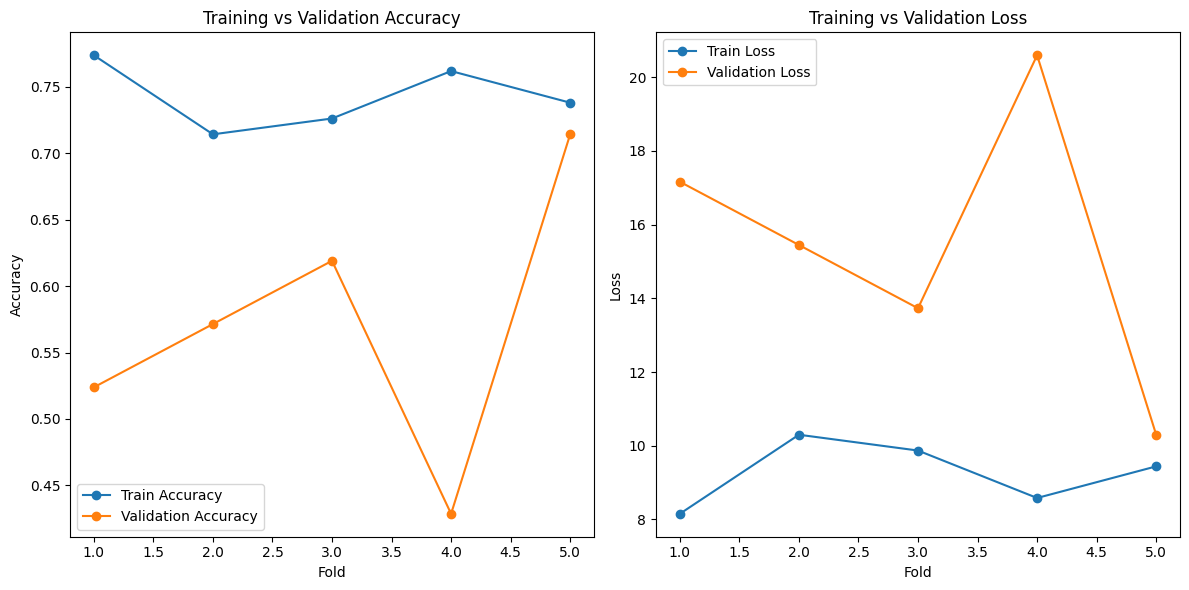

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import KFold
import pandas as pd

k = 5

alpha = 0.01

kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Lists to store fold-wise metrics
fold_results = []

for fold, (train_index, val_index) in enumerate(kf.split(X_temp), 1):
    # Split into training and validation sets for this fold
    X_train_fold, X_val_fold = X_temp.iloc[train_index], X_temp.iloc[val_index]
    y_train_fold, y_val_fold = y_temp.iloc[train_index], y_temp.iloc[val_index]

    # Calculate priors
    prior_positive = y_train_fold.mean()
    prior_negative = 1 - prior_positive
    priors = {0: prior_negative, 1: prior_positive}

    # Calculate likelihoods with Laplace smoothing
    likelihoods = {}
    for col in X_train_fold.columns:
        likelihoods[col] = {}
        for outcome in [0, 1]:
            likelihoods[col][outcome] = (
                (X_train_fold[y_train_fold == outcome][col].value_counts() + alpha) /
                (y_train_fold.value_counts()[outcome] + alpha * X_train_fold[col].nunique())
            ).to_dict()

    # Training Phase
    train_predictions = []
    for i in range(len(X_train_fold)):
        instance = X_train_fold.iloc[i].to_dict()
        posteriors = {outcome: priors[outcome] for outcome in priors}
        for feature, value in instance.items():
            for outcome in priors:
                posteriors[outcome] *= likelihoods[feature].get(outcome, {}).get(value, alpha)
        train_predictions.append(max(posteriors, key=posteriors.get))

    # Validation Phase
    val_predictions = []
    for i in range(len(X_val_fold)):
        instance = X_val_fold.iloc[i].to_dict()
        posteriors = {outcome: priors[outcome] for outcome in priors}
        for feature, value in instance.items():
            for outcome in priors:
                posteriors[outcome] *= likelihoods[feature].get(outcome, {}).get(value, alpha)
        val_predictions.append(max(posteriors, key=posteriors.get))

    # Calculate metrics
    train_accuracy = accuracy_score(y_train_fold, train_predictions)
    val_accuracy = accuracy_score(y_val_fold, val_predictions)
    train_loss = log_loss(y_train_fold, train_predictions)
    val_loss = log_loss(y_val_fold, val_predictions)

    # Store fold metrics
    fold_results.append({
        'Fold': fold,
        'Train Accuracy': train_accuracy,
        'Validation Accuracy': val_accuracy,
        'Train Loss': train_loss,
        'Validation Loss': val_loss
    })

# Convert results to a DataFrame for display
results_df = pd.DataFrame(fold_results)
print("Cross-Validation Results:")
print(results_df)

# Evaluate on Test Set
test_predictions = []
priors_test = {0: prior_negative, 1: prior_positive}
for i in range(len(X_test)):
    instance = X_test.iloc[i].to_dict()
    posteriors = {outcome: priors_test[outcome] for outcome in priors_test}
    for feature, value in instance.items():
        for outcome in priors_test:
            posteriors[outcome] *= likelihoods.get(feature, {}).get(outcome, {}).get(value, alpha)
    test_predictions.append(max(posteriors, key=posteriors.get))

test_accuracy = accuracy_score(y_test, test_predictions)
test_loss = log_loss(y_test, test_predictions)

print(f"\nTest Set Results: Accuracy = {test_accuracy:.2f}, Loss = {test_loss:.2f}")

# Plot Cross-Validation Metrics
plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(results_df['Fold'], results_df['Train Accuracy'], label='Train Accuracy', marker='o')
plt.plot(results_df['Fold'], results_df['Validation Accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(results_df['Fold'], results_df['Train Loss'], label='Train Loss', marker='o')
plt.plot(results_df['Fold'], results_df['Validation Loss'], label='Validation Loss', marker='o')
plt.title('Training vs Validation Loss')
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

K-Fold Cross-Validation makes sure that all data points are used for both training and validation, which is useful since we have a limited dataset. Every data point gets a chance to be in the test set exactly once, so the model is validated across the entire dataset.

In [ ]:
test_accuracy

0.7358490566037735

Confusion Matrix:
[[16  8]
 [ 6 23]]


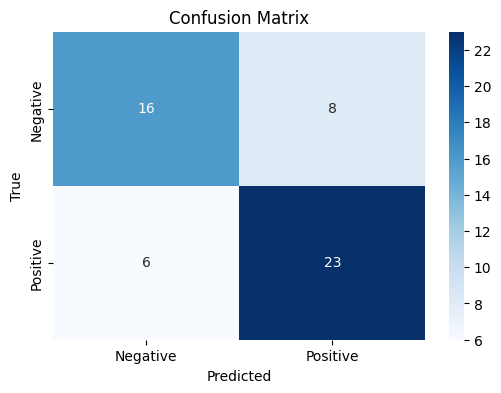

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
# 1. Confusion Matrix
cm = confusion_matrix(y_test, test_predictions)
print(f'Confusion Matrix:\n{cm}')

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Adding the regularization term to prior did nothing and in fact made the model worse. The alpha function helped a little and with a lower value the accuracy rate improved

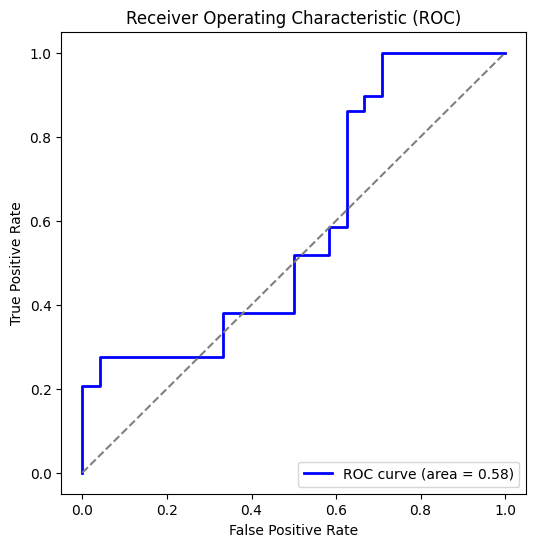

AUC Score: 0.5848


In [ ]:

# 2. ROC Curve and AUC
# Get probabilities for each class
test_probs = []
for i in range(len(X_test)):
    instance = X_test.iloc[i].to_dict()
    posteriors = compute_posterior(instance, priors, likelihoods)
    # Convert posteriors to probabilities (normalizing them)
    prob_pos = posteriors.get(1, 0) / (posteriors.get(0, 0) + posteriors.get(1, 0))
    test_probs.append(prob_pos)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, test_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
plt.title('Receiver Operating Characteristic (ROC)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# 3. AUC Score
print(f'AUC Score: {roc_auc:.4f}')

In [ ]:
from sklearn.metrics import classification_report

# Classification Report for the entire validation set (not per instance)
print("Classification Report for Fold:")
print(classification_report(y_val_fold, val_predictions))


Classification Report for Fold:
              precision    recall  f1-score   support

           0       0.61      0.63      0.62        30
           1       0.71      0.69      0.70        39

    accuracy                           0.67        69
   macro avg       0.66      0.66      0.66        69
weighted avg       0.67      0.67      0.67        69



Key Metrics:
Precision: The proportion of positive predictions that were actually correct.
Recall: The proportion of actual positives that were correctly identified by the model.
F1-Score: The harmonic mean of precision and recall, offering a balance between the two.
Support: The number of true instances for each class in the validation fold.
Breakdown of the Report:
Class 0 (Negative):
Precision: 0.61 – 61% of the predictions that were labeled as class 0 (Negative) were correct.
Recall: 0.63 – 63% of actual Negative instances were correctly predicted as Negative.
F1-Score: 0.62 – The F1 score combines precision and recall into one metric, showing a decent balance between the two.
Class 1 (Positive):
Precision: 0.71 – 71% of the predictions labeled as class 1 (Positive) were correct.
Recall: 0.69 – 69% of actual Positive instances were correctly predicted as Positive.
F1-Score: 0.70 – A good balance between precision and recall for the Positive class.
Overall Performance:
Accuracy: 0.67 – 67% of the predictions were correct overall.
Macro Average: 0.66 – The average across both classes (0 and 1) without considering class imbalance.
Weighted Average: 0.67 – The average, weighted by the number of instances in each class. This accounts for class imbalance.
Insights and Next Steps:
Class Imbalance: Class 1 (Positive) has a higher precision and recall compared to class 0 (Negative), which suggests a possible imbalance between the two classes. You might want to explore techniques like SMOTE (Synthetic Minority Over-sampling Technique) or class weight adjustment to address this imbalance.

Improving Precision/Recall: There’s room to improve both precision and recall for class 0 (Negative), which is slightly lower than for class 1. This could be due to feature selection or regularization, so reviewing those could help.

Overfitting: If you observe a significant difference in accuracy between training and validation sets, overfitting may be a concern. Cross-validation results across folds should help assess if the model generalizes well.

